# Generate data

Model is not converging.  Current: -2848876.7767291213 is not greater than -2636710.1945731416. Delta is -212166.5821559797
Model is not converging.  Current: -190244.78264426847 is not greater than -71125.99584904185. Delta is -119118.78679522662


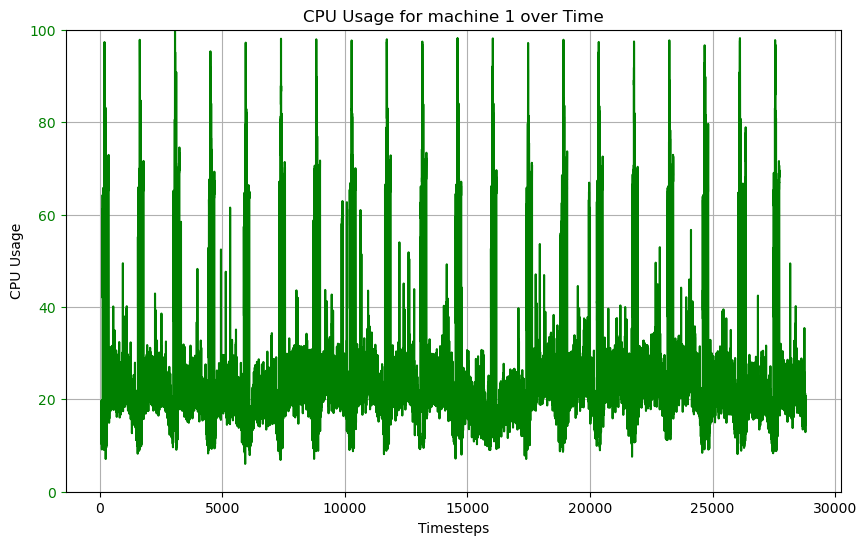

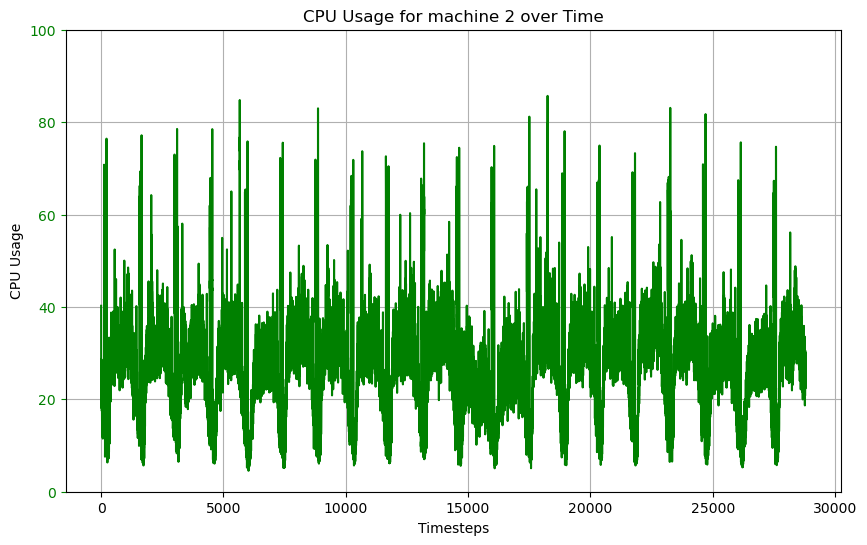

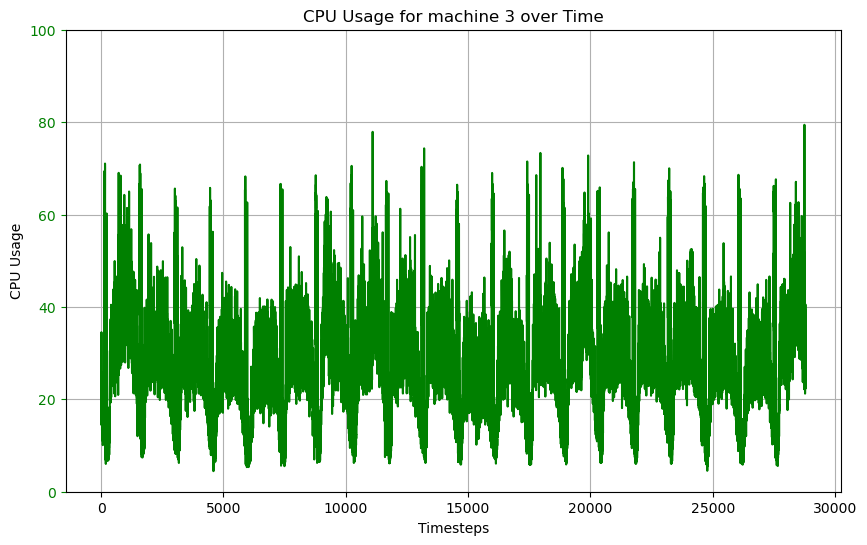

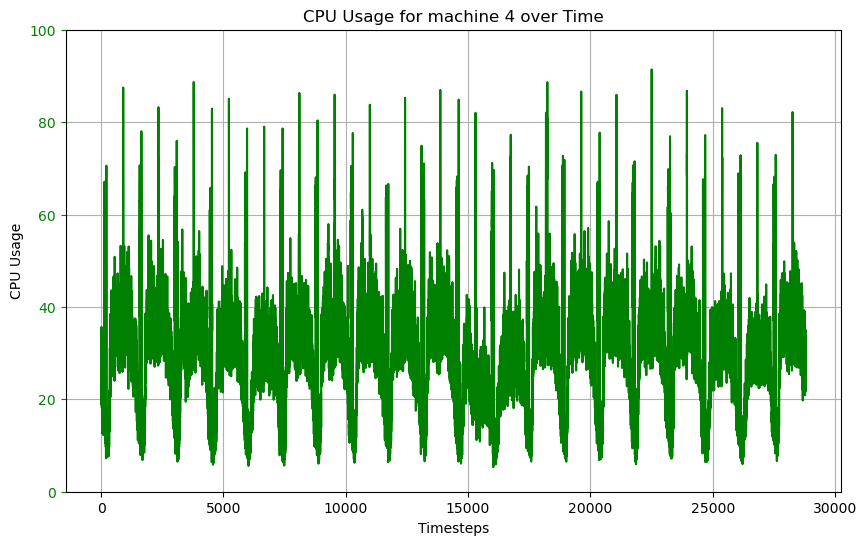

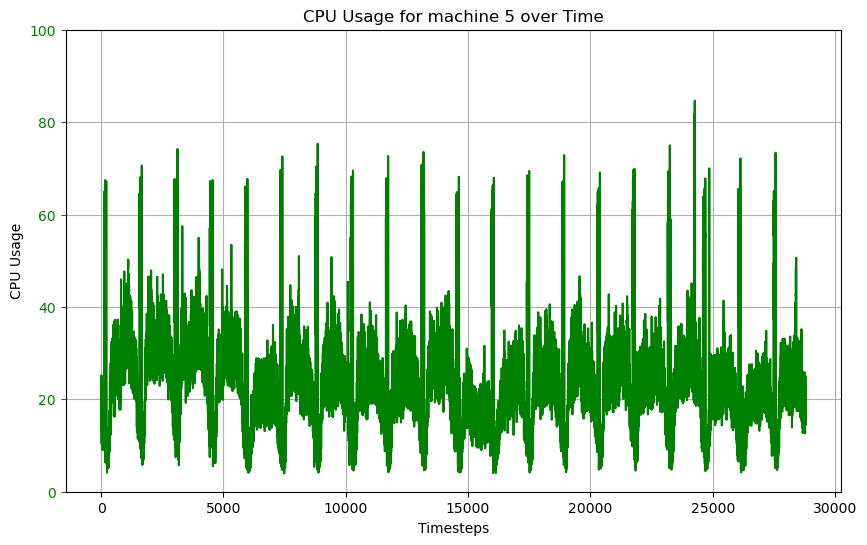

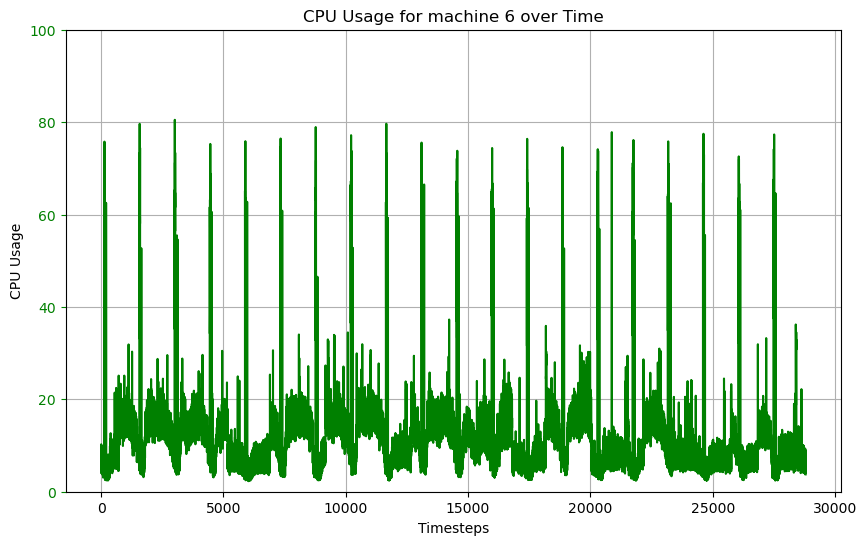

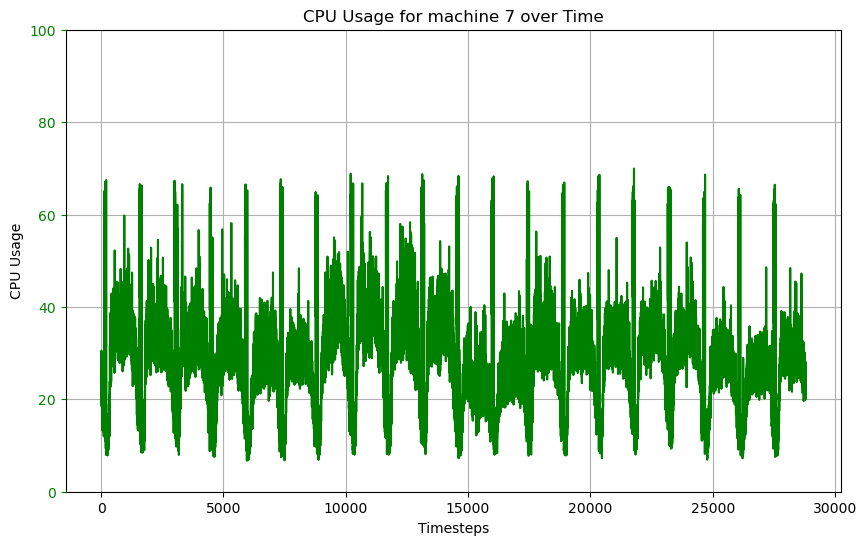

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

def convert_datetime_format(datetime_str):
    target_format = "%d/%m/%Y %H:%M"
    try:
        datetime_obj = parser.parse(datetime_str)
        return datetime_obj.strftime(target_format)
    except (ValueError, TypeError):
        print(f"Invalid datetime format: {datetime_str}")
        return None

def insert_missing_minutes(group):
    group = group.sort_values(by='datetime').reset_index(drop=True)
    all_rows = []
    for i in range(len(group) - 1):
        curr_time = group.iloc[i]['datetime']
        next_time = group.iloc[i + 1]['datetime']
        while next_time - curr_time > pd.Timedelta(minutes=1):
            curr_time = curr_time + pd.Timedelta(minutes=1)
            # Insert a new row for the missing minute with NaN for 'value'
            new_row = pd.DataFrame({
                'datetime': [curr_time],
                'machine_id': [group.iloc[i]['machine_id']],
                'cpu_usage': [np.nan]
            })
            all_rows.append(new_row)
    if all_rows:
        group = pd.concat([group] + all_rows).sort_values(by='datetime').reset_index(drop=True)
    return group

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    except:
        df['datetime'] = df['datetime'].apply(convert_datetime_format)
    df['cpu_usage'].replace(0, np.nan, inplace=True)
    if 'machine_id' in df.columns:
        df['machine_id'] = df['machine_id'].fillna(method='bfill')
        df['machine_id'] = pd.Categorical(df['machine_id']).codes + 1
    else:
        df['machine_id'] = 1
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    df = df.groupby('machine_id', group_keys=False).apply(insert_missing_minutes)
    df['cpu_usage'] = df.groupby('machine_id', group_keys=False)['cpu_usage'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    # Drop any rows with NaN values that were created due to shifting
    df.dropna(inplace=True)
    column_to_move = df.pop('cpu_usage')
    df.insert(1, 'cpu_usage', column_to_move)
    df = create_time_features(df)
    all_features_no_timestamp = df.columns[1:len(df.columns)]
    features_for_hmm = df[all_features_no_timestamp].values

    num_states = 10
    model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

    model.fit(features_for_hmm)

    for i, row in enumerate(model.transmat_):
        if row.sum() == 0:
            model.transmat_[i] = np.full(model.n_components, 1 / model.n_components)

    hidden_states = model.predict(features_for_hmm)

    df['hidden_state'] = hidden_states
    return df

cpu_data = pd.read_csv('../Utilities\csv/cpu_usage_data_train.csv')
cpu_data_test = pd.read_csv('../Utilities\csv/cpu_usage_data_test.csv')
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)
cpu_data_test = create_additional_features(cpu_data_test, 'cpu_usage', lags)

file_path = "../Utilities/csv/cpu_usage_train.csv"
cpu_data.to_csv(file_path, index=False)
file_path = "../Utilities/csv/cpu_usage_test.csv"
cpu_data_test.to_csv(file_path, index=False)

for machine_id, machine_data in cpu_data.groupby('machine_id'):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax.tick_params('y', colors='g')
    plt.xlabel('Timesteps')
    plt.ylabel('CPU Usage')
    ax.set_ylim(0, 100)
    plt.title(f'CPU Usage for machine {machine_id} over Time')
    plt.grid(True)
    plt.show()

# Generate Replicas

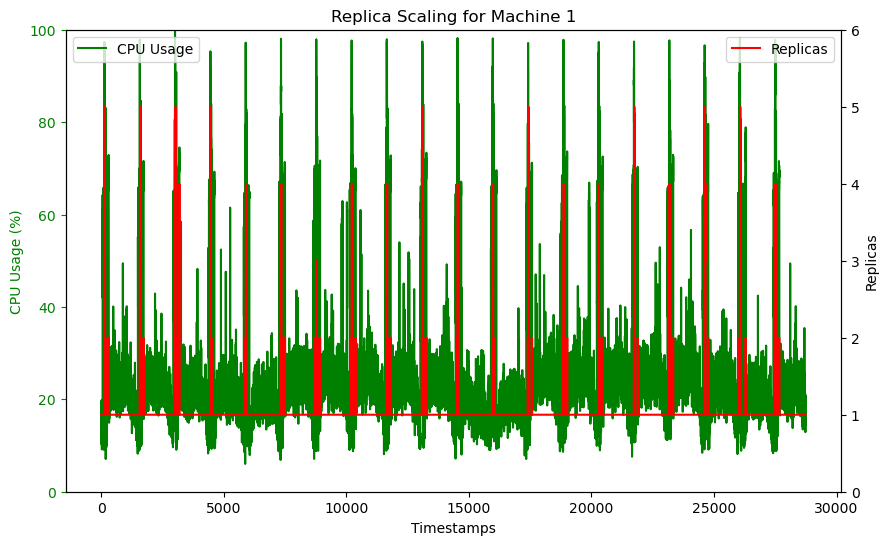

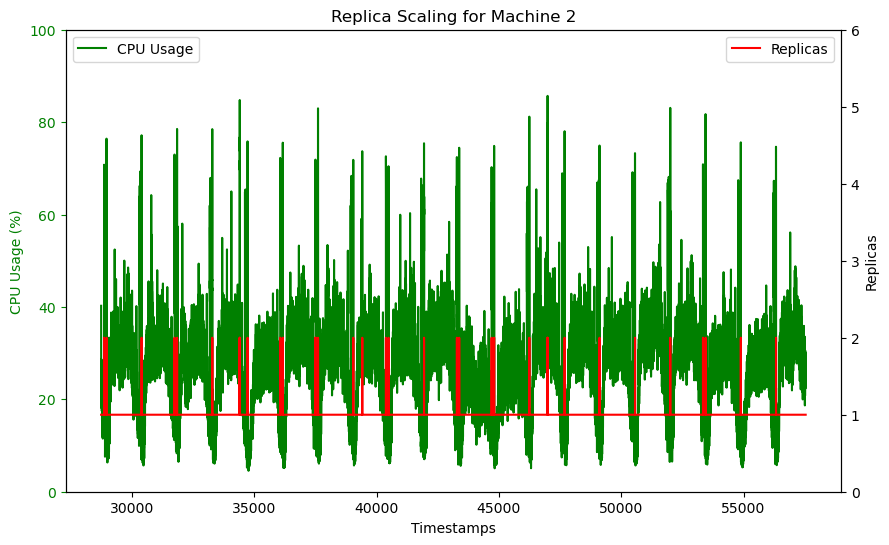

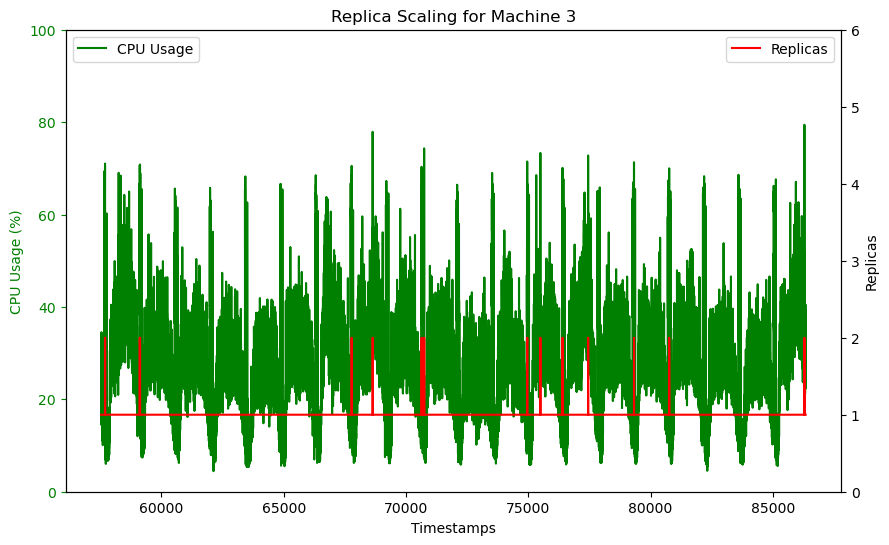

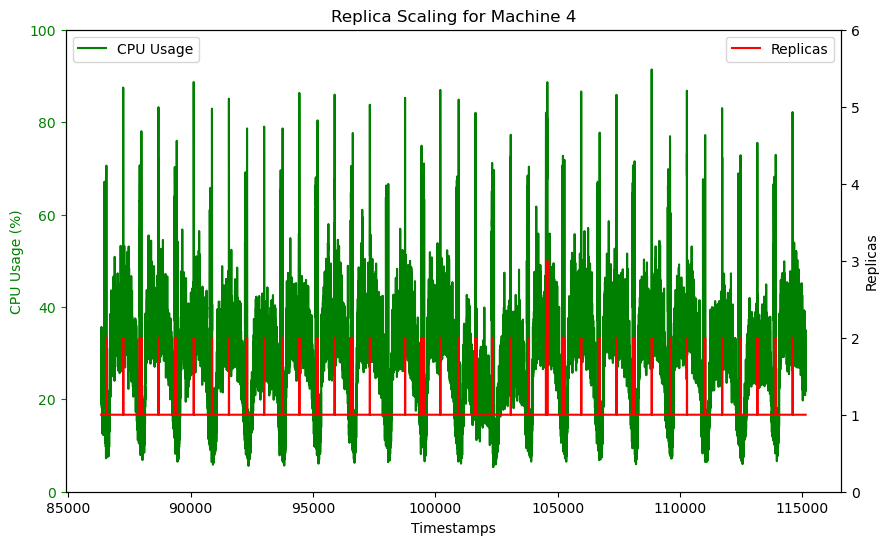

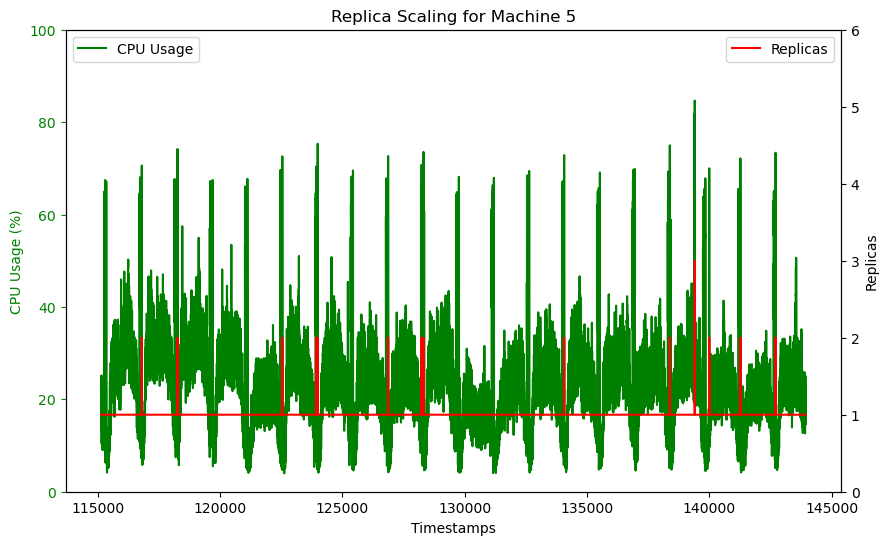

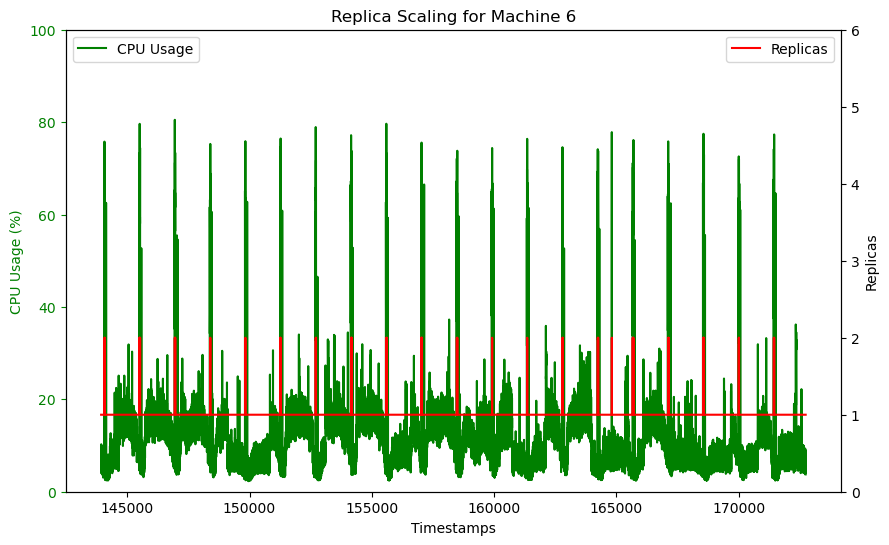

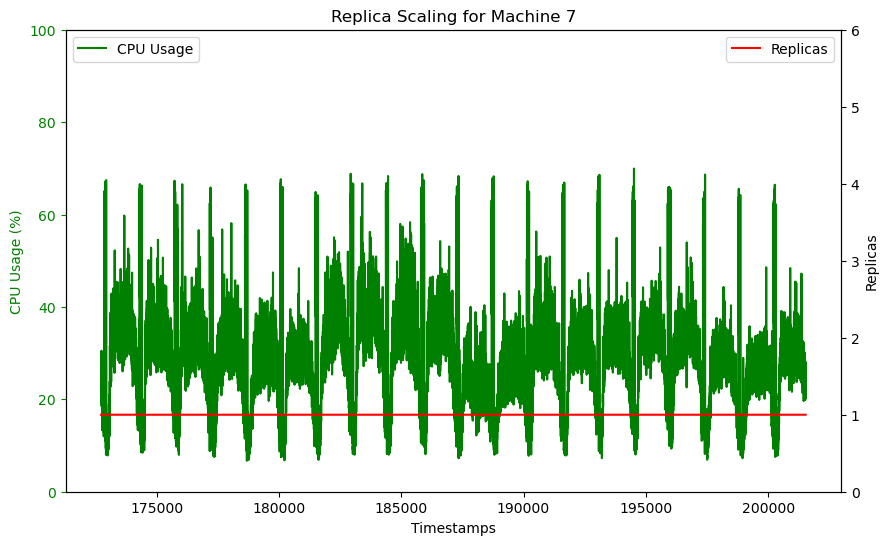

In [5]:
# Variables for tracking cooldown periods and consecutive low CPU usage
scale_up_cooldown = 5  # No scale-up allowed for 5 timesteps after the last scale-up
scale_down_consecutive = 2  # CPU must be below threshold for 2 consecutive timesteps to scale down

initial_replicas = 1
threshold = 70  # SLA threshold at 70%

# Function to generate replicas for each machine separately
def generate_replicas_for_machine(machine_data):
    time_since_last_scale_up = scale_up_cooldown  # Initialize at cooldown to allow immediate scaling if needed
    consecutive_below_threshold = 0  # Track consecutive timesteps below threshold
    current_replicas = initial_replicas  # Start with initial number of replicas

    replicas = []  # List to store the replicas for this machine

    # Iterate through CPU usage data for this machine
    for cpu_usage in machine_data['cpu_usage']:
        # Check if scaling up is allowed
        if cpu_usage >= threshold:
            if time_since_last_scale_up >= scale_up_cooldown:
                current_replicas += 1  # Scale up
                time_since_last_scale_up = 0  # Reset cooldown
            else:
                time_since_last_scale_up += 1  # Increment cooldown timer
            consecutive_below_threshold = 0  # Reset consecutive below counter

        # Check for scaling down
        else:
            consecutive_below_threshold += 1
            if consecutive_below_threshold >= scale_down_consecutive and current_replicas > 1:
                current_replicas -= 1  # Scale down
                consecutive_below_threshold = 0  # Reset consecutive counter
            time_since_last_scale_up += 1  # Continue cooldown for scale up

        # Append the current number of replicas to the list
        replicas.append(current_replicas)

    # Add the 'replicas' column to the machine data
    machine_data['replicas'] = replicas
    return machine_data

# Group by 'machine_id' and apply the replica generation function to each group
cpu_data_with_replicas = cpu_data.groupby('machine_id', group_keys=False).apply(generate_replicas_for_machine)

# Reset the index after applying groupby
cpu_data_with_replicas.reset_index(drop=True, inplace=True)

# Plot replicas and CPU usage for each machine
for machine_id, machine_data in cpu_data_with_replicas.groupby('machine_id', group_keys=False):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax1.set_xlabel('Timestamps')
    ax1.set_ylabel('CPU Usage (%)', color='g')
    ax1.tick_params('y', colors='g')
    ax1.set_ylim(0, 100)
    
    ax2 = ax1.twinx()
    ax2.plot(machine_data['replicas'], 'r-', label='Replicas')
    ax2.set_ylabel('Replicas')
    ax2.tick_params('y')
    ax2.set_ylim(0, 6)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Replica Scaling for Machine {machine_id}')
    plt.show()

# Save the dataset with replicas to a CSV file
file_path = "../Utilities/csv/cpu_replicas.csv"
cpu_data_with_replicas.to_csv(file_path, index=False)

# Predict Workload

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
# Load and preprocess data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()  # Separate scaler for the target variable
window_size = 60
prediction_horizon = 10

# Reduce precision and scale features
all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage].astype(np.float32))

# Scale the target (cpu_usage) separately
cpu_data['cpu_usage'] = target_scaler.fit_transform(cpu_data[['cpu_usage']].astype(np.float32))

# Generator function to yield batches
def sequence_generator(group_data, window_size, prediction_horizon, batch_size=128):
    X, y = [], []
    count = 0
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values.astype(np.float32))
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values.astype(np.float32))
        count += 1
        if count >= batch_size:
            yield np.array(X), np.array(y)
            X, y = [], []
            count = 0
    if X and y:
        yield np.array(X), np.array(y)

# Prepare train, val, test splits
X_all, y_all = [], []
for _, group_data in cpu_data.groupby('machine_id'):
    for X_batch, y_batch in sequence_generator(group_data, window_size, prediction_horizon):
        X_all.append(X_batch)
        y_all.append(y_batch)

# Convert list of batches to array and reduce precision
X_all = np.concatenate(X_all, axis=0).astype(np.float32)
y_all = np.concatenate(y_all, axis=0).astype(np.float32)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Build model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(100, 3, activation='relu'),
    BatchNormalization(),
    Conv1D(50, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    LSTM(150, return_sequences=True),
    Dropout(0.4),
    LSTM(100, return_sequences=True),
    Dropout(0.4),
    LSTM(50, return_sequences=False),
    Dense(prediction_horizon)
])

# Compile and train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_idea.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

lstm_model.compile(optimizer="adam", loss=Huber())
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val),
                         verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Evaluate and inverse transform to interpret RMSE in original scale
mse_lstm = lstm_model.evaluate(X_test, y_test)
rmse_lstm = np.sqrt(mse_lstm)

# Invert scaling for y_test and predictions for interpretability
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
preds = lstm_model.predict(X_test)
preds_rescaled = target_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
mse_lstm_unscaled = mean_squared_error(preds_rescaled, y_test_rescaled)
rmse_lstm_unscaled = np.sqrt(mse_lstm_unscaled)

print(f"RMSE (evaluate): {rmse_lstm}, MSE (evaluate): {mse_lstm}")
print(f"RMSE (predicted): {rmse_lstm_unscaled}, MSE (predicted): {mse_lstm_unscaled}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 100)        │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 50)         │        15,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 150)        │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 28, 100)        │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,460 (1.03 MB)

 Trainable params: 270,160 (1.03 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 398s 205ms/step - loss: 0.0047 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 2/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 419s 193ms/step - loss: 0.0023 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 384s 193ms/step - loss: 0.0020 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 397s 201ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 327s 171ms/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 248s 131ms/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 249s 132ms/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 263s 133ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 259s 131ms/step - loss: 0.0015

# Forecast prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

lstm_model = load_model('best_model_2.keras')

# Invert scaling for y_test and predictions for interpretability
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
preds = lstm_model.predict(X_test)
y_pred_unscaled = target_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)

y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()

r_squared = r2_score(y_test_rescaled_flat, predictions_rescaled_flat)
mae = mean_absolute_error(y_test_rescaled_flat, predictions_rescaled_flat) * 100
mse_lstm = mean_squared_error(y_test_rescaled_flat, predictions_rescaled_flat)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}, R-Squared: {r_squared}, MAE: {mae}")
# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.4)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

NameError: name 'target_scaler' is not defined

# Predicting number of replicas

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error (MSE): 0.006791290158334831


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


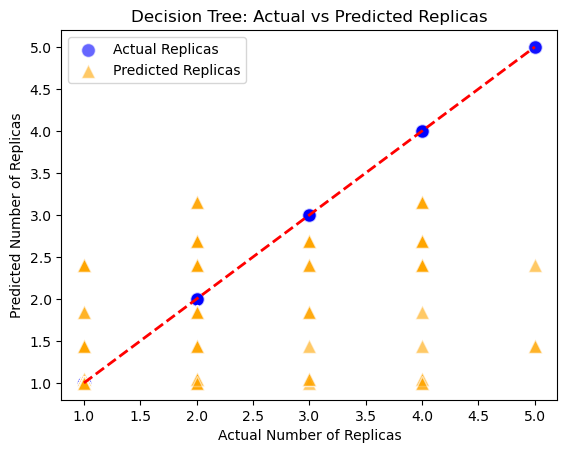

1257/1257 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step
Predicted number of replicas for 10 mins future CPU usage (44.86097717285156): 1.001187625333411


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')

# Split the data
X = replicas_data[['cpu_usage']]
y = replicas_data['replicas']
X_train_replicas, X_test_replicas, y_train_replicas, y_test_replicas = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_replicas.values, y_train_replicas.values)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Predict with the best model
best_model = grid_search.best_estimator_
# Save the model
joblib.dump(best_model, 'decision_tree_model.pkl')
y_pred_replicas = best_model.predict(X_test_replicas)

# Evaluate the model
mse = mean_squared_error(y_test_replicas, y_pred_replicas)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.scatter(y_test_replicas, y_test_replicas, color='blue', alpha=0.6, edgecolors='w', s=100, label='Actual Replicas', marker='o')
plt.scatter(y_test_replicas, y_pred_replicas, color='orange', alpha=0.6, edgecolors='w', s=100, label='Predicted Replicas', marker='^')
plt.plot([y_test_replicas.min(), y_test_replicas.max()], [y_test_replicas.min(), y_test_replicas.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Number of Replicas')
plt.ylabel('Predicted Number of Replicas')
plt.legend()
plt.title('Decision Tree: Actual vs Predicted Replicas')
plt.show()

# Predict using LSTM output
predictions = lstm_model.predict(X_test)

predictions_rescaled = target_scaler.inverse_transform(predictions)

future_replicas = best_model.predict(predictions_rescaled.reshape(-1, 1))
print(f'Predicted number of replicas for 10 mins future CPU usage ({predictions_rescaled[0][-1]}): {future_replicas[0]}')

# Detect Burst

In [ ]:
import time
from kubernetes import client, config
import requests
import json
from datetime import datetime, timedelta
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Set the OMP_NUM_THREADS environment variable to 1
os.environ["OMP_NUM_THREADS"] = "1"

def get_time_range():
    end_time = int(time.time())  # Current timestamp in seconds
    start_time = end_time - (1 * 3600) # Hours in seconds
    return start_time, end_time

# Prometheus server URL (adjust according to your setup)
PROMETHEUS_URL = "http://localhost:9090"

def query_prometheus_range(query, start_time, end_time, step):
    params = {
        'query': query,
        'start': start_time,
        'end': end_time,
        'step': step  # Interval between points (e.g., 60s = 1 minute intervals)
    }
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query_range", params=params)
    return response.json()

# Function to get CPU usage for a pod over the past hour
def get_pod_cpu_usage_range(pod_name, start_time, end_time):
    # Prometheus query to get CPU usage over the last hour (rate over 1 minute)
    query = f'avg((sum(rate(container_cpu_usage_seconds_total{{pod=~"{pod_name}-.*"}}[1m])) by (pod)) / (sum(kube_pod_container_resource_limits{{pod=~"{pod_name}-.*", resource="cpu"}}) by (pod))) * 100'

    # Query Prometheus with a 60-second step interval
    result = query_prometheus_range(query, start_time, end_time, step="60")

    return result

# Function to convert the Prometheus result to a pandas DataFrame
def prometheus_to_dataframe(prometheus_result):
    if not prometheus_result or 'data' not in prometheus_result:
        return pd.DataFrame()  # Return an empty DataFrame if there's no data

    # Extract the 'values' from the first result (assuming only one pod)
    values = prometheus_result['data']['result'][0]['values']

    # Create a DataFrame from the values
    df = pd.DataFrame(values, columns=['datetime', 'cpu_usage'])

    # Convert UNIX timestamp to human-readable datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

    # Convert the value column to float
    df['cpu_usage'] = df['cpu_usage'].astype(float)

    return df

def get_dataset():
    start_time, end_time = get_time_range()
    pod_cpu_data = get_pod_cpu_usage_range("microsvc", start_time, end_time)
    cluster_data_1h = prometheus_to_dataframe(pod_cpu_data)
    cluster_data_1h['datetime'] = pd.to_datetime(cluster_data_1h['datetime']).dt.floor('T')
    lags = [5, 10, 60]
    full_1h_data = create_additional_features(cluster_data_1h, 'cpu_usage', lags)
    full_1h_data.dropna(inplace=True)
    return full_1h_data

window_size = 60
prediction_horizon = 10

def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

# Load kube config
config.load_kube_config()
# If running inside the cluster, use:
# config.load_incluster_config()

def scale_out(additional_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = current_replicas + additional_replicas
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled out to {new_replicas} replicas.")
    return new_replicas

def scale_in(remove_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = max(current_replicas - remove_replicas, 1)
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled in to {new_replicas} replicas.")
    return new_replicas

def detect_burst(monitoring_interval, window_size, resource_prediction_model, replica_prediction_model, replicas):
    is_burst = False
    replicas_before_burst = 1
    past_predictions = np.array([])
    feature_scaler_burst = MinMaxScaler()
    target_scaler_burst = MinMaxScaler()
    # while True:
    x = 0
    while x < 5:
        x += 1
        time.sleep(monitoring_interval)
        full_1h_data = get_dataset()
        all_columns_no_datetime_cpu = full_1h_data.columns[2:len(full_1h_data.columns)]
        full_1h_data[all_columns_no_datetime_cpu] = feature_scaler_burst.fit_transform(full_1h_data[all_columns_no_datetime_cpu])
        full_1h_data[['cpu_usage']] = target_scaler_burst.fit_transform(full_1h_data[['cpu_usage']])
        # In 10 minute increments
        prediction_steps = 10
        prediction_lookup = 60
        predict_data, predict_labels = create_lstm_sequences(full_1h_data, prediction_lookup, prediction_steps)
        cpu_predictions = resource_prediction_model.predict(predict_data, verbose=0)
        predictions_rescaled = target_scaler_burst.inverse_transform(cpu_predictions)
        n_predicted = replica_prediction_model.predict(predictions_rescaled.reshape(-1, 1))
        past_predictions = np.append(past_predictions, n_predicted)
        sd_max = 0
        n_max = 0
        for i in range(1, window_size + 1):
            sigma_i = np.std(past_predictions)

            if sigma_i > sd_max:
                sd_max = sigma_i
                n_max = max(past_predictions.flatten())

        if sd_max >= 2 and not is_burst:
            # Detected burst, increase replicas to n_max
            replicas_during_burst = n_max
            is_burst = True
            replicas_before_burst = n_predicted  # Store current predicted replicas before burst
        elif sd_max >= 2 and is_burst:
            # Continuation of the burst
            replicas_during_burst = n_max
        elif sd_max < 2 and is_burst:
            if replicas_before_burst > n_predicted:
                # Burst ending, scale back to predicted replicas
                replicas_during_burst = n_predicted
                is_burst = False
                replicas_before_burst = 1
            else:
                # Keep scaling at n_max
                replicas_during_burst = n_max
        else:
            # Normal condition, set replicas to predicted
            replicas_during_burst = n_predicted[0]

        current_replica_count = int(replicas)
        replicas_during_burst = int(replicas_during_burst)

        if current_replica_count < replicas_during_burst:
            additional_replicas = int(replicas_during_burst - current_replica_count)
            replicas = scale_out(additional_replicas, 'microsvc', namespace='default')
        elif current_replica_count > replicas_during_burst:
            replica_difference = int(current_replica_count - replicas_during_burst)
            replicas = scale_in(replica_difference, 'microsvc', namespace='default')
        else:
            print("No replica update needed")
        # Log the updated replica count
        print(f"Updated replica count: {replicas}")


api = client.AppsV1Api()
deployment = api.read_namespaced_deployment('microsvc', namespace='default')
replicas = deployment.spec.replicas
print(f"Original replica count: {replicas}")
lstm_model = load_model('best_model.keras')
best_model = joblib.load('decision_tree_model.pkl')
detect_burst(60, 10, lstm_model, best_model, replicas)

Original replica count: 1


Model is not converging.  Current: 2671.4002746040137 is not greater than 2767.5720278695408. Delta is -96.17175326552706


No replica update needed
Updated replica count: 1


Model is not converging.  Current: 2946.38002389692 is not greater than 2946.3800454268044. Delta is -2.1529884179471992e-05


No replica update needed
Updated replica count: 1


Model is not converging.  Current: 3192.5080521810855 is not greater than 3648.522168352069. Delta is -456.01411617098347


No replica update needed
Updated replica count: 1


Model is not converging.  Current: 2244.958178880894 is not greater than 2600.2149375740883. Delta is -355.2567586931941


No replica update needed
Updated replica count: 1
No replica update needed
Updated replica count: 1


# Create HPA System

In [ ]:
# import joblib

# joblib.dump(model, 'cpu_usage_predictor.pkl')
# joblib.dump(best_model, 'replicas_predictor.pkl')
